[View in Colaboratory](https://colab.research.google.com/github/ZackPashkin/Evaluating-a-Data-Model/blob/master/Exploratory_Data_Analysis_Datalab,_BigQuery.ipynb)

In [0]:
!pip install --upgrade google-cloud-bigquery

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

client = bigquery.Client()


In [0]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE DEP_DELAY >= 10 AND RAND() < 0.01
"""
df = client.query(sql).to_dataframe()
df.describe()


,ARR_DELAY,DEP_DELAY
count,12856.000000,12926.000000
mean,46.673771,51.430837
std,65.277179,63.306670
min,-41.000000,10.000000
25%,11.000000,17.000000
50%,27.000000,30.000000
75%,60.000000,61.000000
max,948.000000,985.000000


/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:584: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/envs/py2env/lib/python2.7/site-packages/seaborn/categorical.py:812: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


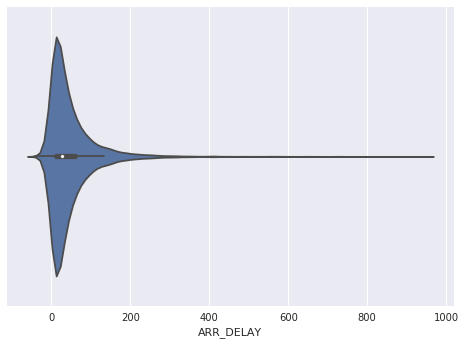

In [0]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=df, x='ARR_DELAY', inner='box', orient='h')

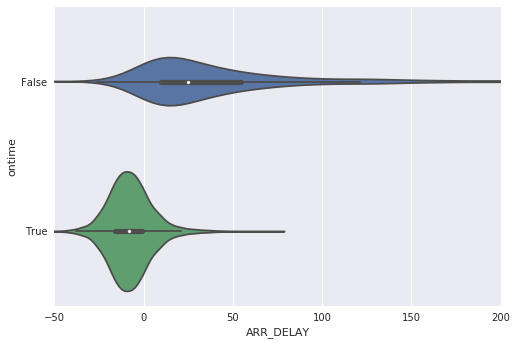

In [0]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001
"""

df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                   inner='box', orient='h')
ax.set_xlim(-50,200);


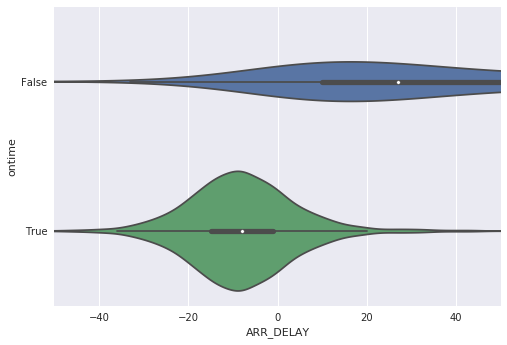

In [0]:
sql = """
SELECT ARR_DELAY, DEP_DELAY
FROM `flights.tzcorr`
WHERE RAND() < 0.001"""

df = client.query(sql).to_dataframe()
df['ontime'] = df['DEP_DELAY'] < 10
ax = sns.violinplot(data=df, x='ARR_DELAY', y='ontime',
                   inner='box', orient='h',gridsize=1000)
ax.set_xlim(-50,50);

This clearly shows that the 10 minute departure delay threshold definitely divides the dataset into two very different datasets, which is clearly shown by the box plots in the center of these two distributions. Flights that depart 10 or more minutes late are clearly asymmetrically distributed towards longer delay times. Flights that depart less than 10 minutes late are centered around the peak arrival time.

One approach to eliminating outliers from the dataset is to filter the dataset so that you only look at delay values within a particular range. For a dataset that has a few hundred thousand examples you can look at a range based on the standard deviation of the value you are interested in.

In [0]:
sql = """

SELECT
  AVG(DEP_DELAY) - 3*STDDEV(DEP_DELAY) AS filtermin,
  AVG(DEP_DELAY) + 3*STDDEV(DEP_DELAY) AS filtermax
FROM
  `flights.tzcorr`
"""
df = client.query(sql).to_dataframe()
df.describe()

,filtermin,filtermax
count,1.000000,1.000000
mean,-101.872669,120.612986
std,NaN,NaN
min,-101.872669,120.612986
25%,-101.872669,120.612986
50%,-101.872669,120.612986
75%,-101.872669,120.612986
max,-101.872669,120.612986


In [0]:
depdelayquery = """
SELECT
  DEP_DELAY,
  arrival_delay,
  stddev_arrival_delay,
  numflights
FROM (
  SELECT
    DEP_DELAY,
    AVG(ARR_DELAY) AS arrival_delay,
    STDDEV(ARR_DELAY) AS stddev_arrival_delay,
    COUNT(ARR_DELAY) AS numflights
  FROM
    `flights.tzcorr`
  GROUP BY
    DEP_DELAY )
WHERE
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = client.query(depdelayquery).to_dataframe()
depdelay.head()

,DEP_DELAY,arrival_delay,stddev_arrival_delay,numflights
0,-23.0,-23.888646,11.432163,458
1,-22.0,-23.227488,12.590133,633
2,-21.0,-22.299781,11.558313,914
3,-20.0,-21.407821,12.066489,1432
4,-19.0,-20.430769,11.910134,1950


plot average arrival delay and the standard deviation for each delay:

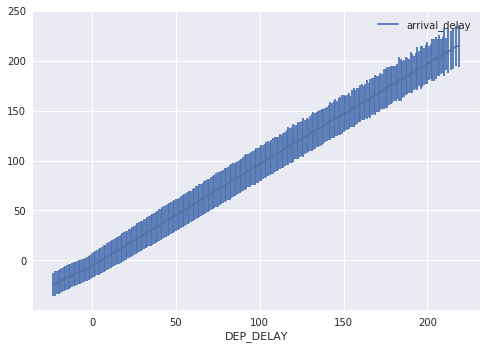

In [0]:
ax = depdelay.plot(kind='line',
                   x='DEP_DELAY',
                   y='arrival_delay',
                   yerr='stddev_arrival_delay');

This demonstrates that there does appear to be a linear relationship between departure delay and arrival delay. It also shows that the standard deviation of the arrival delay for each departure delay is very uniform and close to 10 minutes over the whole range.

plot the intersection of the 15 minute delay line with the 30% arrival delay probability line.

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


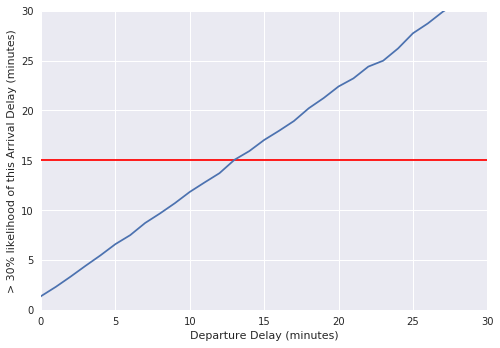

In [0]:
Z_30 = 0.52
depdelay['arr_delay_30'] = (
  (Z_30 * depdelay['stddev_arrival_delay'])
  + depdelay['arrival_delay']
)
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line',
              x='DEP_DELAY',
              y='arr_delay_30',
              ax=ax,
              ylim=(0, 30),
              xlim=(0, 30),
              legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');

The following query breaks up the arrival delays for each departure delay into 100 bins and then selects the arrival delay for the 70th bin as the appropriate value. The 70th bin contains the value that will occur 30% of the time. You then chart the results again to find the intersection of the 15 minute delay line with the 30% probability line you have now established empirically.

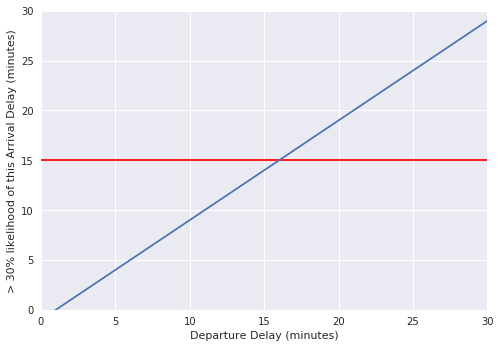

In [0]:
depdelayquery2 = """
SELECT
  DEP_DELAY,
  APPROX_QUANTILES(ARR_DELAY, 101)[OFFSET(70)] AS arrival_delay,
  COUNT(ARR_DELAY) AS numflights
FROM
  `flights.tzcorr`
GROUP BY
  DEP_DELAY
HAVING
  numflights > 370
ORDER BY
  DEP_DELAY
"""
depdelay = client.query(depdelayquery2).to_dataframe()
plt.axhline(y=15, color='r')
ax = plt.axes()
depdelay.plot(kind='line',
              x='DEP_DELAY',
              y='arrival_delay',
              ax=ax,
              ylim=(0, 30),
              xlim=(0, 30),
              legend=False)
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('> 30% likelihood of this Arrival Delay (minutes)');